# Basic Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from medpy import io
from radiomics import featureextractor, imageoperations
import six
import os
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
from sklearn.metrics import roc_auc_score
import radiomics


import sys
sys.path.append('../../')


%load_ext autoreload
%autoreload 2
from radiomics_util import *

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_path = "/data1/practical-sose23/morphometric/data/"
seg_guer_path = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Guerbet23_resampled/"
#seg_bosma_path = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/"

#path_to_t2w = "/data1/practical-sose23/morphometric/data/10021/10021_1000021_t2w.mha"
#path_to_adc = "/data1/practical-sose23/morphometric/data/10021/10021_1000021_adc.mha"
#path_to_segmentation = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/10021_1000021.nii.gz"

In [4]:
gt = pd.read_csv("/data1/practical-sose23/morphometric/picai_labels/clinical_information/marksheet.csv")
gt

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO


In [5]:
result = iterate_over_data(lambda x: np.asarray(sitk.ReadImage(x).GetSpacing()),image_modality="adc")

In [6]:
df = pd.DataFrame(result)
df.mean()

0    1.856927
1    1.856927
2    3.252332
dtype: float64

# Single Image Process

(116, 114, 31) (-119.22891521454, -85.812474306467, -80.369742947333) (1.0, 0.0, 0.0, 0.0, 0.9198214958019287, 0.39233712016670375, 0.0, -0.39233712016670375, 0.9198214958019287) (1.75438594818, 1.75438594818, 3.2999999825580133)
(116, 114, 31) (-119.22891235351562, -85.8124771118164, -80.36974334716797) (1.0, 0.0, 0.0, 0.0, 0.9198214986087353, 0.39233710766328717, 0.0, -0.3923371135862375, 0.9198215011350878) (1.7543859481811523, 1.7543859481811523, 3.299999952316284)


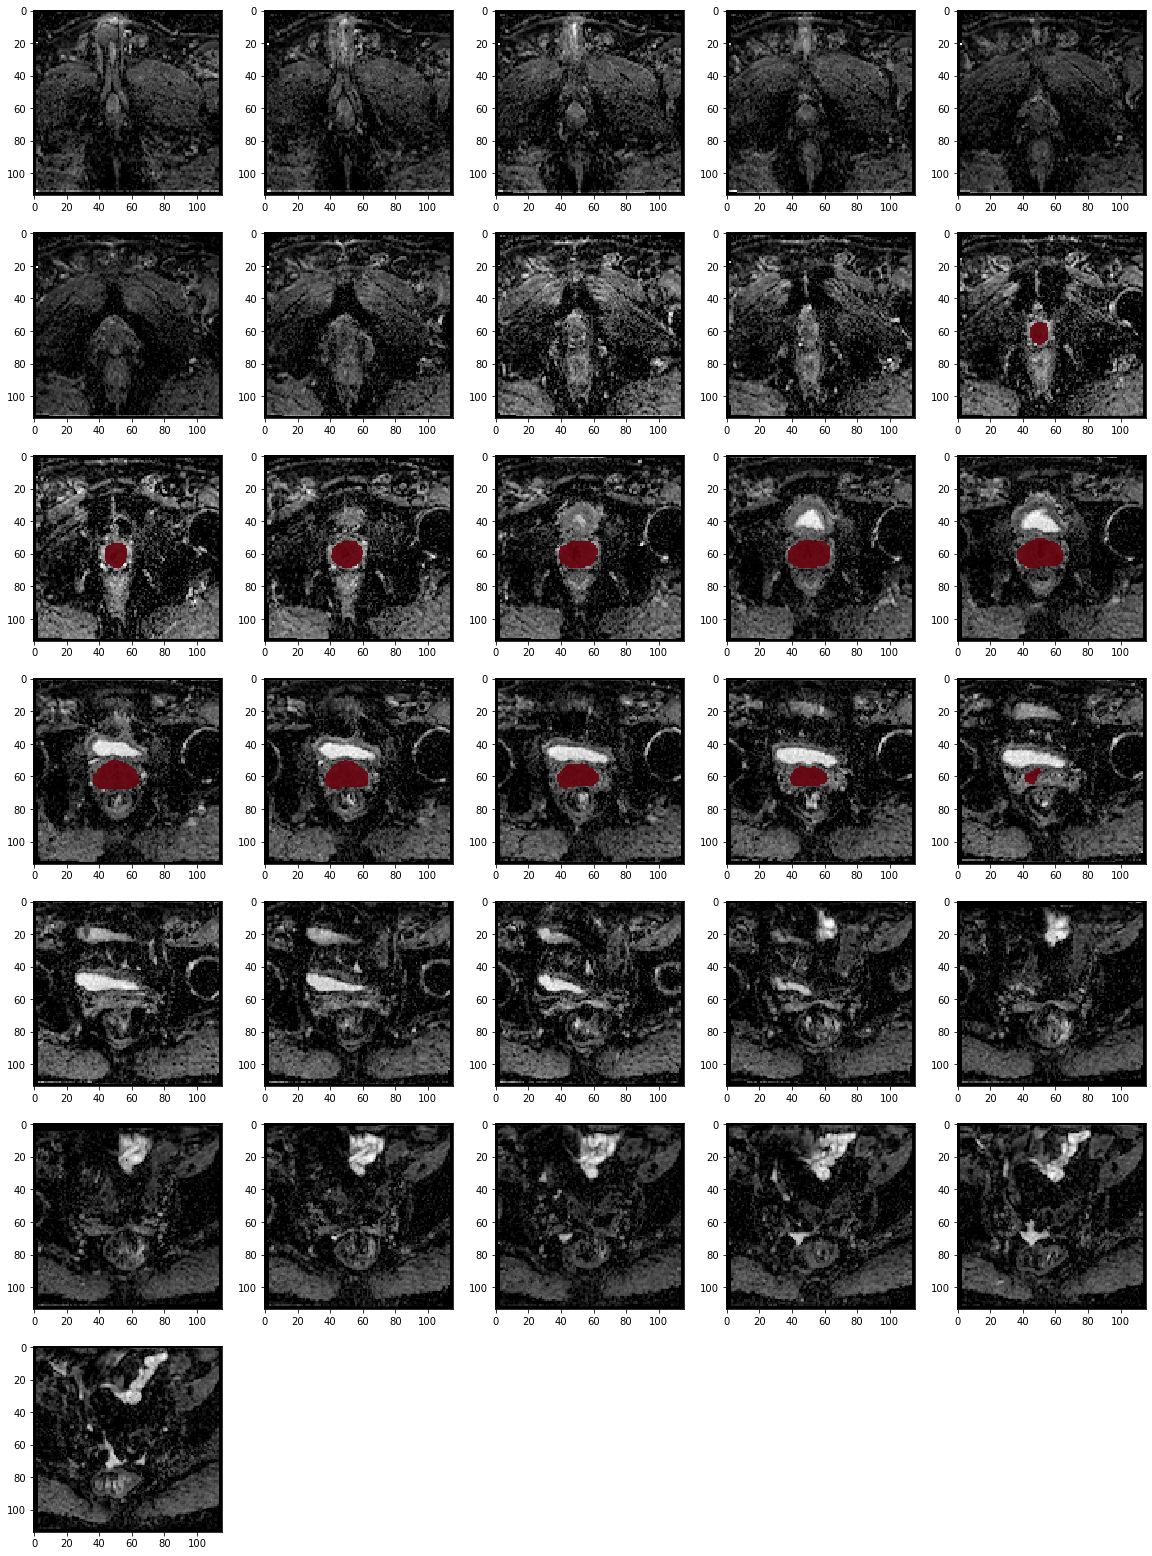

In [18]:
# pipeline for a single image
from radiomics_util import *

#load image
image, mask = get_image_and_segmentaion(10000, 1000000, "adc")

print(image.GetSize(), image.GetOrigin(),image.GetDirection(), image.GetSpacing())
print(mask.GetSize(), mask.GetOrigin(),mask.GetDirection(), mask.GetSpacing())

plot_sitk(image, mask)

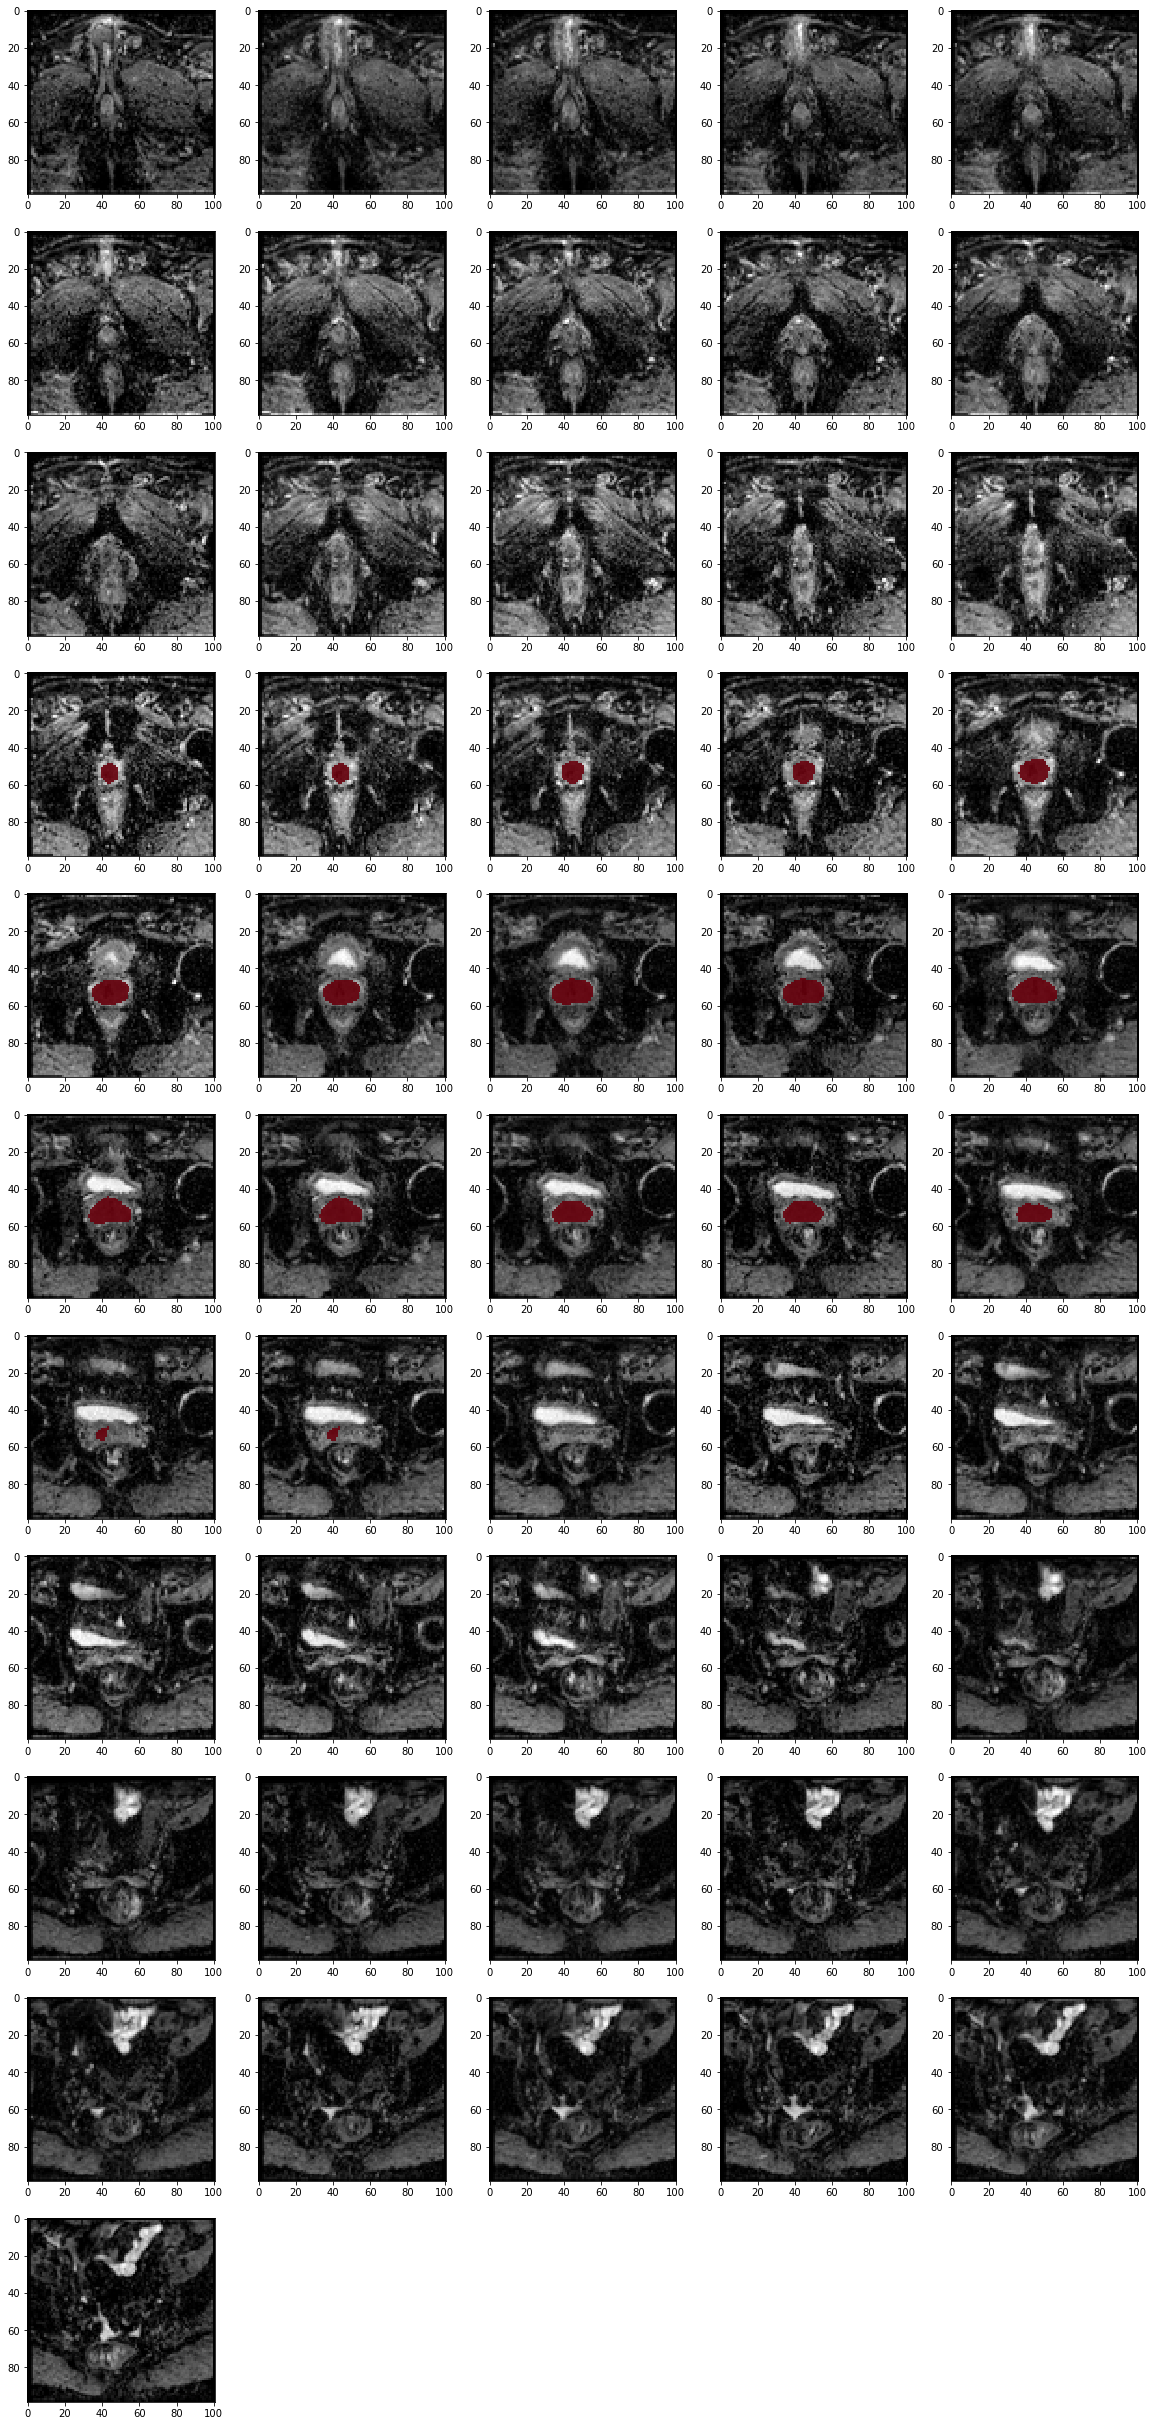

In [19]:
desired_voxel_shape = [2, 2, 2]  # Isotropic voxel shape

resampled_image, resampled_mask = resample_image(image, mask, desired_voxel_shape)
corrected_image = apply_bias_field_correction(resampled_image, resampled_mask)

plot_sitk(resampled_image, resampled_mask)

In [20]:
extractor = featureextractor.RadiomicsFeatureExtractor()
results = extractor.execute(corrected_image, resampled_mask)
data = pd.DataFrame(results.items())
data = data.transpose()
data.columns = data.iloc[0]
data = data.drop(data.index[[0]])
data

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},223222e31ac41c2c492595ca4cc9cd34e652eea4,3D,"(2.0, 2.0, 2.0)",...,1365.4843633060932,0.001568689351241885,6.950237948543093,0.5504748505100246,3.8864971572640323,0.08197866562839283,0.0030578827910509488,9806.45939819743,0.17404112121140794,6.774587649914775


In [21]:
b_box, _ = imageoperations.checkMask(corrected_image, resampled_mask)
ellips_vol = (b_box[1]-b_box[0]) * (b_box[3]-b_box[2]) * (b_box[5]-b_box[4]) * 0.52
ellips_vol

2870.4

In [22]:
data["original_shape_MeshVolume"]

1    22579.666666666668
Name: original_shape_MeshVolume, dtype: object

# Apply to Dataset

In [24]:
# pipeline for several images
radiomics.setVerbosity(40)
df = pd.DataFrame([])

for index, row in gt.iterrows():
    if isinstance(row['prostate_volume'], float):
        print(str(index), end= "\r")

        desired_voxel_shape = [2,2,2]  # Isotropic voxel shape
        extractor = featureextractor.RadiomicsFeatureExtractor("../radiomics/pyradiomics_params.yaml")
        #extractor.disableAllFeatures()
        #extractor.enableFeatureClassByName("shape")

        image, mask = get_image_and_segmentaion(row["patient_id"], row["study_id"],"adc")

        try: 

            resampled_image, resampled_mask = resample_image(image, mask, desired_voxel_shape)
            corrected_image = apply_bias_field_correction(resampled_image, resampled_mask)

            results = extractor.execute(corrected_image, resampled_mask)
            data = pd.DataFrame(results.items())
            data = data.transpose()
            data.columns = data.iloc[0]
            data = data.drop(data.index[[0]])

            data["original_shape_MeshVolume"] /= 1000 

            b_box, _ = imageoperations.checkMask(corrected_image, resampled_mask)
            ellips_vol = (b_box[1]-b_box[0]) * (b_box[3]-b_box[2]) * (b_box[5]-b_box[4]) * 0.52 * np.asarray(image.GetSpacing()).prod()/1000

            data["ellipse_vol"] =  ellips_vol
            data["patient_id"] =  row["patient_id"]
            data["study_id"] =  row["study_id"]
            data["prostate_volume"] = row["prostate_volume"]

            df = df.append(data)

        except Exception as e:
            print("Exception occured for patient: {1}, and study_id: {2}".format(row["patient_id"], row["study_id"]))
            print(e)

df
df.to_pickle("../radiomics/df_adc_all_all-features_resample_bias-corrected.pkl")

In [25]:

df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,ellipse_vol,patient_id,study_id,prostate_volume
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},223222e31ac41c2c492595ca4cc9cd34e652eea4,3D,"(2.0, 2.0, 2.0)",...,2582.7996834329933,182.57676749912065,0.28133518730214563,0.0017020923999421496,0.006513236251134446,0.0004993064371440754,29.154570,10000,1000000,55.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},2969eb8bd1ff9a0ddaa09c4d85385f5db7c7665f,3D,"(2.0, 2.0, 2.0)",...,2777.0175274635794,173.56364231093806,0.2500041639523866,0.0015477373068549295,0.006189098581914566,0.0003873969880900204,125.379075,10001,1000001,102.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},c8796131980850d2cbf1d18dc8f166a65ba7eb5b,3D,"(2.0, 2.0, 2.0)",...,2466.3989444082167,229.59444031219434,0.3518427005216824,0.0016537864554952901,0.005719109538540684,0.0006374556847339416,71.760002,10002,1000002,74.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6a73b6bb15902ff5ccd48254e63f5f1211217ad4,3D,"(2.0, 2.0, 2.0)",...,2764.41773495793,172.9169324992062,0.2504651035878711,0.0015755434930430682,0.006258803746919392,0.00040472842957398715,72.334082,10003,1000003,71.5
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},eb8b03473f38851f3ea8089ad54b530f3d1cfac5,3D,"(2.0, 2.0, 2.0)",...,2748.5376528298166,171.78539427627686,0.2500462186945376,0.0015866646163004506,0.00633894395197835,0.0003985947823809755,83.026943,10004,1000004,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},34069a349677acc4f81ca333daa9c658ef38f9ae,3D,"(2.0, 2.0, 2.0)",...,684.0597190573279,684.0597190573279,1.0,0.0015996710244046864,0.0015996710244046864,0.0015996710244046864,56.609280,11471,1001495,62.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},eb393f94ea9f4bc392c5f3445cb55b2abe4ec6a0,3D,"(2.0, 2.0, 2.0)",...,2711.3931989423436,169.46954996958067,0.2501009102396106,0.001635573298608956,0.006529568809181441,0.0004120744209658346,38.061504,11472,1001496,44.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},12a77aca5b16208d34f36c51ae1802dcb71b0c0c,3D,"(2.0, 2.0, 2.0)",...,690.6530415705339,690.6530415705339,1.0,0.0015676568795226613,0.0015676568795226613,0.0015676568795226613,79.073280,11473,1001497,87.0
1,v3.1.0,1.24.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d21cf35933f90caf3b7844c77143529a63df9cc4,3D,"(2.0, 2.0, 2.0)",...,2753.3139786406955,172.0919252110851,0.25006661720448087,0.001573722820508751,0.006290932866456454,0.00039442030902182536,118.799405,11474,1001498,83.0


# Analysis of Results

In [8]:
df1 = pd.read_pickle("../radiomics/df_t2w_all_all-features_resample_bias-corrected.pkl")
df2 = pd.read_pickle("../radiomics/df_adc_all_all-features_resample_bias-corrected.pkl")
df1

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,ellipse_vol,patient_id,study_id,prostate_volume
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},b7e07a24b98b72b6783555843e1c8df3ee92c986,3D,"(0.28125, 0.28125, 3.2999999825580133)",...,13943.148017817188,0.6331386704433819,0.007370307806137414,0.04544061435931626,11.636874745836023,0.00029631336438916357,31.627291,10000,1000000,55.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},506f40b3dd1be17b2bfe821bcfcf7864fcc412b1,3D,"(0.30000001192093, 0.30000001192093, 3.6000000...",...,11233.75609535354,0.5935250469041303,0.007952367162358927,0.041430117006279965,7.4169872044022505,0.0003385122084686867,88.094831,10001,1000001,102.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f7152603cd28a4571523d8ad09de1693032aca0c,3D,"(0.5, 0.5, 3.000000075935057)",...,8345.461382310685,0.22505014119304018,0.006597650757225366,0.1006349365690926,24.71857791368083,0.000706770048292158,59.557682,10002,1000002,74.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},4a78c3a51494a7e2318643b480cfcbc52fd99a45,3D,"(0.5, 0.5, 3.000000080342142)",...,6514.693153017427,0.6678222348024903,0.011376834340760863,0.059340941033063956,8.616535047923623,0.0006878207755164997,61.460102,10003,1000003,71.5
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6acbf87411c739e33cdc4b3be587ebb88738a2a2,3D,"(0.30000001192093, 0.30000001192093, 3.5999999...",...,7067.529045081282,3.6482982781461666,0.025084888142404373,0.02209866795539414,1.5064993578636905,0.000562019400089227,59.366459,10004,1000004,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},263acfd0a27332fc99becebd8301b09163000c07,3D,"(0.5, 0.5, 3.5000000091804995)",...,8764.054696829162,0.744365014585416,0.010738500830972837,0.048682693403121265,7.559701094010482,0.0005153198387689947,45.555510,11471,1001495,62.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},686aac1fd169cd485ed3edda4cb8ce5876915417,3D,"(0.30000001192093, 0.30000001192093, 3.5999999...",...,5537.745182671091,20.28184681445372,0.0674635792119614,0.008615858585351532,0.20749396659857963,0.0006496413680494103,29.612047,11472,1001496,44.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},3402dc991b36399113689938ff0b85273a9b0264,3D,"(0.30000001192093, 0.30000001192093, 3.6000000...",...,10745.400786459772,0.7994737965687021,0.009042691426220096,0.045653201258894084,8.666895433043111,0.00037103949464335946,58.687654,11473,1001497,87.0
1,v3.0.1,1.20.3,2.2.1,1.1.1,3.9.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f12b387cd19f1f27544e353d060897f12e8e36fe,3D,"(0.625, 0.625, 3.599999876696945)",...,8060.871251431122,0.5586066861557434,0.009425688135718134,0.050971627092910046,7.894140990518342,0.0005101327840272178,75.624410,11474,1001498,83.0


In [9]:

merged_df = df1.merge(gt[["study_id", "case_csPCa"]], on='study_id')
merged_df = merged_df.merge(df2, on="study_id")
merged_df['case_csPCa'] = merged_df['case_csPCa'].map({'YES': 1, 'NO': 0})

columns_to_drop = merged_df.filter(regex='^diagnostics_').columns
merged_df = merged_df.drop(columns=columns_to_drop)
#merged_df = merged_df.drop(columns=["lesion_GS", "lesion_ISUP", "case_ISUP", "mri_date","histopath_type", "psa", "psad", "study_id", "prostate_volume_x", "prostate_volume_y","patient_age"])
#merged_df = merged_df.dropna()

data = merged_df.iloc[:,0:-1]
target = merged_df["case_csPCa"]
target


0       0
1       0
2       0
3       0
4       0
       ..
1495    1
1496    1
1497    0
1498    0
1499    1
Name: case_csPCa, Length: 1500, dtype: int64

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the dataframe
data_standardized = scaler.fit_transform(data)
# Convert the standardized array back to a dataframe
data_standardized = pd.DataFrame(data_standardized, columns=data.columns)

## Use correlation for feature selection

In [11]:
#df = scaler.inverse_transform(data_standardized)
#df = pd.DataFrame(df, columns=data_standardized.columns)

df = data_standardized.copy()
df["target"] = target
df["target"]

get_high_correlation_features(df)

Index(['original_shape_LeastAxisLength_x',
       'original_shape_Maximum2DDiameterRow_x',
       'original_shape_Maximum3DDiameter_x', 'original_shape_MeshVolume_x',
       'original_shape_MinorAxisLength_x', 'original_shape_SurfaceArea_x',
       'original_shape_SurfaceVolumeRatio_x', 'original_shape_VoxelVolume_x',
       'original_glrlm_GrayLevelNonUniformity_x',
       'original_glrlm_RunLengthNonUniformity_x',
       'original_gldm_DependenceNonUniformity_x', 'ellipse_vol_x',
       'prostate_volume_x', 'case_csPCa', 'original_shape_LeastAxisLength_y',
       'original_shape_Maximum2DDiameterRow_y',
       'original_shape_Maximum2DDiameterSlice_y',
       'original_shape_Maximum3DDiameter_y', 'original_shape_MeshVolume_y',
       'original_shape_MinorAxisLength_y', 'original_shape_SurfaceArea_y',
       'original_shape_SurfaceVolumeRatio_y', 'original_shape_VoxelVolume_y',
       'original_glrlm_GrayLevelNonUniformity_y',
       'original_glrlm_LongRunEmphasis_y',
       'origina

## Use Lasso for feature selection

In [32]:
df = pd.concat((data_standardized, target), axis = 1)
df = df.dropna()
df


,original_shape_Elongation_x,original_shape_Flatness_x,original_shape_LeastAxisLength_x,original_shape_MajorAxisLength_x,original_shape_Maximum2DDiameterColumn_x,original_shape_Maximum2DDiameterRow_x,original_shape_Maximum2DDiameterSlice_x,original_shape_Maximum3DDiameter_x,original_shape_MeshVolume_x,original_shape_MinorAxisLength_x,...,original_gldm_LargeDependenceEmphasis_y,original_gldm_LargeDependenceHighGrayLevelEmphasis_y,original_gldm_LargeDependenceLowGrayLevelEmphasis_y,original_gldm_LowGrayLevelEmphasis_y,original_gldm_SmallDependenceEmphasis_y,original_gldm_SmallDependenceHighGrayLevelEmphasis_y,original_gldm_SmallDependenceLowGrayLevelEmphasis_y,ellipse_vol_y,patient_id_y,case_csPCa
0,-1.156444,-1.079635,-0.898317,-0.402426,-0.388945,-0.881081,-0.405067,-0.617631,-0.709914,-0.930191,...,-2.021095,0.431049,-0.544219,-0.506631,1.390102,0.643171,-0.449475,-0.699650,-1.730138,0
1,-0.009719,0.548263,1.299851,1.015605,1.214725,0.939336,0.921991,0.929337,1.054196,0.980413,...,1.164855,0.648975,-0.584716,-0.602958,-1.176790,0.488405,-0.666035,1.433135,-1.727786,0
2,1.363853,1.148818,0.646499,0.016851,0.091322,0.320780,0.106088,0.092331,0.324443,0.745234,...,-0.577436,0.300439,-0.332964,-0.289858,0.586785,0.263999,-0.182138,0.244686,-1.725434,0
3,1.328455,1.119142,0.684202,0.068867,-0.168292,0.514528,0.143121,0.172846,0.382509,0.782814,...,0.858948,0.634837,-0.587622,-0.601540,-0.714379,0.521687,-0.632496,0.257410,-1.723082,0
4,-0.493525,-1.118746,-0.160333,0.521546,0.670846,0.165059,0.700963,0.276782,0.034246,0.232675,...,0.447902,0.617019,-0.592706,-0.602828,-0.529437,0.559952,-0.644366,0.494414,-1.720730,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.057856,0.733380,0.246993,-0.159847,0.253493,-0.079859,0.337031,-0.040324,-0.229706,-0.166950,...,0.138087,-1.699469,1.709000,1.702882,-0.313144,-1.702909,1.679876,-0.091125,1.729655,1
1496,-1.656278,-1.500526,-0.993985,-0.256742,-0.363645,-1.097593,-0.311997,-0.574164,-0.731241,-1.055434,...,-0.486898,0.575340,-0.603111,-0.602660,0.283904,0.650969,-0.618281,-0.502230,1.732007,1
1497,0.474895,0.186118,0.435678,0.342638,-0.001583,0.783716,0.059793,0.513392,0.342395,0.605718,...,0.802139,-1.692071,1.738625,1.702882,-0.845532,-1.718194,1.617924,0.406782,1.734359,0
1498,1.337293,1.575854,0.930930,0.067598,0.259592,0.538282,0.565297,0.290449,0.405182,0.786114,...,0.568810,0.622378,-0.591329,-0.602766,-0.744657,0.537028,-0.652444,1.287299,1.736711,0


In [33]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate



In [35]:
#df.iloc[:,:-1]
df["case_csPCa"]

,case_csPCa,case_csPCa
0,-0.628768,0
1,-0.628768,0
2,-0.628768,0
3,-0.628768,0
4,-0.628768,0
...,...,...
1495,1.590412,1
1496,1.590412,1
1497,-0.628768,0
1498,-0.628768,0


In [40]:

# Initialize the Lasso model
lasso = Lasso(alpha=1, max_iter=1000)  # You can adjust the value of alpha (regularization strength) as needed

result = cross_validate(lasso, X=df.iloc[:,:-1], y=df["case_csPCa"], cv=5, scoring="accuracy", return_train_score=True, return_estimator=True)
print(result)
estimators = result["estimator"]
test_scores = result["test_score"]
train_scores = result["train_score"]
print("test scores: ", test_scores.mean())
print("train scores:", train_scores.mean())

features = np.asarray([])
for estimator in estimators:
    feature_importances = estimator.coef_
    # Create a mask to identify the selected features
    selected_features = data_standardized.columns[feature_importances != 0]
    features = np.concatenate((features, selected_features))
    # Print the selected features
    print("Selected features:", list(selected_features))

{'fit_time': array([0.0032084 , 0.00316763, 0.00252795, 0.00297856, 0.00252223]), 'score_time': array([0.00145769, 0.00131702, 0.00131607, 0.00131011, 0.00131202]), 'estimator': [Lasso(alpha=1), Lasso(alpha=1), Lasso(alpha=1), Lasso(alpha=1), Lasso(alpha=1)], 'test_score': array([nan, nan, nan, nan, nan]), 'train_score': array([nan, nan, nan, nan, nan])}
test scores:  nan
train scores: nan


/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/u/home/seel/.conda/env

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [31]:
names, freq = np.unique(features, return_counts=True)
result = pd.DataFrame([names, freq]).T
result.sort_values(1)

,0,1
4,original_glrlm_LongRunLowGrayLevelEmphasis,1
5,original_glrlm_ShortRunHighGrayLevelEmphasis,1
9,original_shape_Maximum2DDiameterRow,1
7,original_glszm_SizeZoneNonUniformity,2
12,original_shape_SurfaceVolumeRatio,2
1,original_firstorder_InterquartileRange,3
3,original_glrlm_LongRunEmphasis,3
6,original_glrlm_ShortRunLowGrayLevelEmphasis,3
8,original_shape_Elongation,3
10,original_shape_MinorAxisLength,3


In [ ]:

# Fit the Lasso model on the entire dataset
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_train)
auc = roc_auc_score(y_train, y_pred)
print("AUC train:", auc)

y_pred = lasso.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print("AUC test: ", auc)

# Get the feature importance scores from the Lasso model
feature_importances = lasso.coef_

# Create a mask to identify the selected features
selected_features = data_standardized.columns[feature_importances != 0]

# Print the selected features
print("Selected features:", selected_features)


